In [1]:
import cobra as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import copy as cp
from IPython.display import clear_output

In [2]:
# Load Models

m1 = cb.io.load_matlab_model('AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

M = [m1, m2]


Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [3]:
# Define Media

# AGORA Format
media = {
	'EX_o2(e)': 0, #aerobic/anaerobic
	'EX_h2o(e)': -1000,
	'EX_pi(e)': -1000,
	'EX_fe2(e)': -1000,
	'EX_fe3(e)': -1000,
	'EX_zn2(e)': -1000,
	'EX_so4(e)': -1000,
	'EX_cu2(e)': -1000,
	'EX_k(e)': -1000,
	'EX_mg2(e)': -1000,
	'EX_mn2(e)': -1000,
	'EX_cd2(e)': -1000,
	'EX_cl(e)': -1000,
	'EX_ca2(e)': -1000,
	'EX_cobalt2(e)': -1000,
	'EX_glc_D(e)': -10,
	'EX_nh4(e)': -20,

	'EX_ribflv(e)': -1000,
	'EX_pnto_R(e)': -1000,
	'EX_nac(e)': -1000,
	'EX_his_L(e)': -1000,
	'EX_asn_L(e)': -1000,
	'EX_glycys(e)': -1000,

	'EX_lys_L(e)': -1000,
	'EX_ala_L(e)': -1000,
	'EX_met_L(e)': -1000,
	'EX_leu_L(e)': -1000,
	'EX_hxan(e)': -1000,    
	'EX_ser_L(e)': -1,
}

In [4]:
import gifba

# load models and media:
sim = "test"
models, media = gifba.utils.load_simple_models(sim) # sim. 4a

In [10]:
# Dynamic Simulation (run through 1 time step split int m_n substeps)
def dynamic_simulation(max_substeps, step_size, models, rel_abund, media, EX):
	# count total unique exchange reactions in all models
	N_exs = len(EX)
	dvdt = np.zeros(N_exs)

	flux_results = np.zeros((N_exs, max_substeps, len(models)))
	flux_v_results = np.zeros((N_exs,max_substeps, len(models)))
	vs = np.zeros((N_exs, max_substeps))

	# initialize state vector
	v = np.zeros(N_exs)
	# update media with media fluxes
	dvdt = np.zeros(N_exs)
	for e, flux in media.items():
		ind = EX.index(e)
		dvdt[ind] = -1*flux
	# update state vector with media fluxes
	v = v + dvdt

	# update media with model fluxes
	# loop max_substeps times to smooth dynamics
	for step in range(max_substeps):
		# clear_output(wait=False)
		print('\nStep ' + str(step) + ' of ' + str(max_substeps), "-------------------------")

		vs[:, step] = v #keep track of state vector over time

		v_tmp = v # mmol/ (gt * hr)
		
		for i in range(len(models)):
			print()
			dvdt = np.zeros(N_exs)

			m = models[i]
			rel_abund_i = rel_abund[i]
			# turn off all exchanges
			for exch in m.exchanges:
				exch.lower_bound = 0
				exch.upper_bound = 10000000

			# set model updtake constraints from media concentrations
			for ind, e in enumerate(EX):
				if e in m.exchanges:
					# calculate amount of v available to be fluxed
					flux_lim = v[ind]/rel_abund_i
					m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
					print("Org. ", i+1, ": ", e, "lb: ", flux_lim)
			
			# solve FBA
			sol = m.optimize()
			print("----")
			# update media with model fluxes
			for exch in m.exchanges:
				e, flux = exch.id, sol.fluxes[exch.id] # internal fluxes
				ind = EX.index(e)
				
				print("Internal v for org ", i+1, ", exch ", e, ": ", v[ind])
				dvdt[ind] = (flux*rel_abund_i)*step_size # mmol / (gt * hr^2) # flux velocity = conc accel

				flux_results[ind, step, i] = flux
				flux_v_results[ind, step, i] = dvdt[ind]

			# update state vector with model fluxes
			v_tmp = v_tmp + dvdt
		
		v = v_tmp

	return flux_results, flux_v_results, vs

In [11]:
# Simulation
rel_abund = [0.5, 0.5]
max_substeps = 400
step_size = 0.01

EX = []
for m in models:
	for exch in m.exchanges:
		EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N_exs = len(EX)
x0 = np.zeros(N_exs)

models = cp.deepcopy(models)

Read LP format model from file /tmp/tmppjqhf6so.lp
Reading time = 0.00 seconds
: 6 rows, 14 columns, 24 nonzeros
Read LP format model from file /tmp/tmphe194wrz.lp
Reading time = 0.00 seconds
: 6 rows, 14 columns, 24 nonzeros


In [12]:
results, sum_results, xs = dynamic_simulation(max_substeps, step_size, models, rel_abund, media, EX)


Step 0 of 400 -------------------------

Org.  1 :  Ex_A lb:  20.0
Org.  1 :  Ex_C lb:  0.0
Org.  1 :  exchangeBio1 lb:  0.0
----
Internal v for org  1 , exch  Ex_A :  10.0
Internal v for org  1 , exch  Ex_C :  0.0
Internal v for org  1 , exch  exchangeBio1 :  0.0

Org.  2 :  Ex_A lb:  20.0
Org.  2 :  Ex_C lb:  0.0
Org.  2 :  exchangeBio2 lb:  0.0
----
Internal v for org  2 , exch  Ex_C :  0.0
Internal v for org  2 , exch  Ex_A :  10.0
Internal v for org  2 , exch  exchangeBio2 :  0.0

Step 1 of 400 -------------------------

Org.  1 :  Ex_A lb:  19.8
Org.  1 :  Ex_C lb:  200.0
Org.  1 :  exchangeBio1 lb:  0.2
----
Internal v for org  1 , exch  Ex_A :  9.9
Internal v for org  1 , exch  Ex_C :  100.0
Internal v for org  1 , exch  exchangeBio1 :  0.1

Org.  2 :  Ex_A lb:  19.8
Org.  2 :  Ex_C lb:  200.0
Org.  2 :  exchangeBio2 lb:  0.0
----
Internal v for org  2 , exch  Ex_C :  100.0
Internal v for org  2 , exch  Ex_A :  9.9
Internal v for org  2 , exch  exchangeBio2 :  0.0

Step 2 of 4

[1.00000000e+01 9.90000000e+00 9.70200000e+00 9.50796000e+00
 9.31780080e+00 9.13144478e+00 8.94881589e+00 8.76983957e+00
 8.59444278e+00 8.42255392e+00 8.25410285e+00 8.08902079e+00
 7.92724037e+00 7.76869556e+00 7.61332165e+00 7.46105522e+00
 7.31183412e+00 7.16559743e+00 7.02228549e+00 6.88183978e+00
 6.74420298e+00 6.60931892e+00 6.47713254e+00 6.34758989e+00
 6.22063809e+00 6.09622533e+00 5.97430082e+00 5.85481481e+00
 5.73771851e+00 5.62296414e+00 5.51050486e+00 5.40029476e+00
 5.29228887e+00 5.18644309e+00 5.08271423e+00 4.98105994e+00
 4.88143874e+00 4.78380997e+00 4.68813377e+00 4.59437109e+00
 4.50248367e+00 4.41243400e+00 4.32418532e+00 4.23770161e+00
 4.15294758e+00 4.06988863e+00 3.98849086e+00 3.90872104e+00
 3.83054662e+00 3.75393569e+00 3.67885697e+00 3.60527983e+00
 3.53317424e+00 3.46251075e+00 3.39326054e+00 3.32539533e+00
 3.25888742e+00 3.19370967e+00 3.12983548e+00 3.06723877e+00
 3.00589399e+00 2.94577611e+00 2.88686059e+00 2.82912338e+00
 2.77254091e+00 2.717090

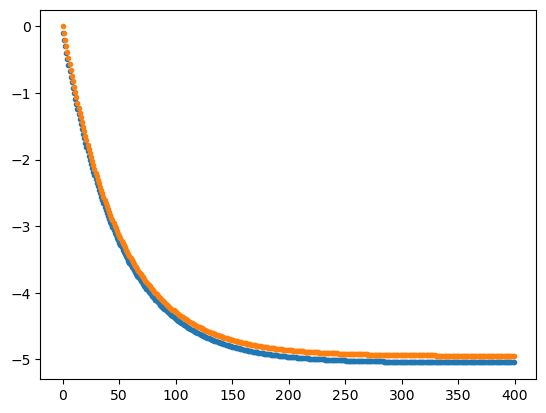

In [13]:
i = EX.index('Ex_A')
print(xs[i,:])
# print(results[i,:,:]) # this can be found by: sum_results / (step_size * rel_abund)
print(sum_results[i,:,:])
plt.plot(sum_results[i,:,0].cumsum(),'.')
plt.plot(sum_results[i,:,1].cumsum(),'.')

run on available
update fluxes available by adding new (not subtracting eaten)
rerun
check difference between two is same


In [ ]:
# Simulation
rel_abund = [0.5, 0.5]
max_substeps = 400
step_size = 0.01

EX = []
for m in M:
	for exch in m.exchanges:
		EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N_exs = len(EX)
x0 = np.zeros(N_exs)

models = cp.deepcopy(M)

Read LP format model from file /tmp/tmpst9afux9.lp
Reading time = 0.00 seconds
: 932 rows, 2064 columns, 8440 nonzeros
Read LP format model from file /tmp/tmp68pmph57.lp
Reading time = 0.00 seconds
: 980 rows, 2102 columns, 8980 nonzeros


In [6]:
results, sum_results, xs = dynamic_simulation(max_substeps, step_size, models, rel_abund, media, EX)

Step 399 of 400


[1.00000000e+01 9.80000000e+00 9.60400000e+00 9.41192000e+00
 9.22368160e+00 9.03920797e+00 8.85842381e+00 8.68125533e+00
 8.50763023e+00 8.33747762e+00 8.17072807e+00 8.00731351e+00
 7.84716724e+00 7.69022389e+00 7.53641941e+00 7.38569103e+00
 7.23797721e+00 7.09321766e+00 6.95135331e+00 6.81232624e+00
 6.67607972e+00 6.54255812e+00 6.41170696e+00 6.28347282e+00
 6.15780337e+00 6.03464730e+00 5.91395435e+00 5.79567526e+00
 5.67976176e+00 5.56616652e+00 5.45484319e+00 5.34574633e+00
 5.23883140e+00 5.13405478e+00 5.03137368e+00 4.93074621e+00
 4.83213128e+00 4.73548866e+00 4.64077888e+00 4.54796331e+00
 4.45700404e+00 4.36786396e+00 4.28050668e+00 4.19489655e+00
 4.11099862e+00 4.02877864e+00 3.94820307e+00 3.86923901e+00
 3.79185423e+00 3.71601714e+00 3.64169680e+00 3.56886286e+00
 3.49748561e+00 3.42753590e+00 3.35898518e+00 3.29180547e+00
 3.22596936e+00 3.16144998e+00 3.09822098e+00 3.03625656e+00
 2.97553143e+00 2.91602080e+00 2.85770038e+00 2.80054637e+00
 2.74453545e+00 2.689644

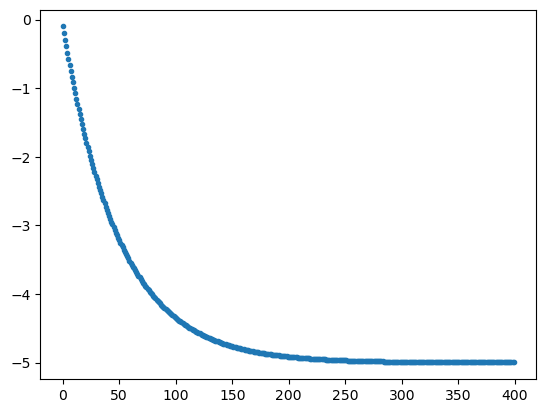

In [7]:
i = EX.index('EX_glc_D(e)')
print(xs[i,:])
# print(results[i,:,:]) # this can be found by: sum_results / (step_size * rel_abund)
print(sum_results[i,:,:])
plt.plot(sum_results[i,:,1].cumsum(),'.')

[ 0.          0.         -0.00175078 -0.00345477 -0.00510729 -0.00670954
 -0.0082627  -0.00976793 -0.01122635 -0.01263906 -0.01400714 -0.01533165
 -0.01661363 -0.01785408 -0.019054   -0.02021434 -0.02133607 -0.0224201
 -0.02346734 -0.02447868 -0.02545499 -0.02639711 -0.02730588 -0.02818211
 -0.02902659 -0.02984009 -0.03062339 -0.03137722 -0.03210231 -0.03279937
 -0.0334691  -0.03411218 -0.03472927 -0.03532103 -0.03588808 -0.03643107
 -0.03695058 -0.03744722 -0.03792158 -0.03837421 -0.03880568 -0.03921653
 -0.0396073  -0.0399785  -0.04033064 -0.04066422 -0.04097973 -0.04127764
 -0.04155841 -0.04182251 -0.04207037 -0.04230243 -0.04251912 -0.04272085
 -0.04290802 -0.04308103 -0.04324027 -0.04338611 -0.04351893 -0.04363909
 -0.04374694 -0.04384283 -0.04392709 -0.04400006 -0.04406205 -0.04411338
 -0.04415436 -0.04418529 -0.04420646 -0.04421815 -0.04422066 -0.04421424
 -0.04419918 -0.04417572 -0.04414413 -0.04410464 -0.04405752 -0.04400299
 -0.04394128 -0.04387262 -0.04379724 -0.04371534 -0.

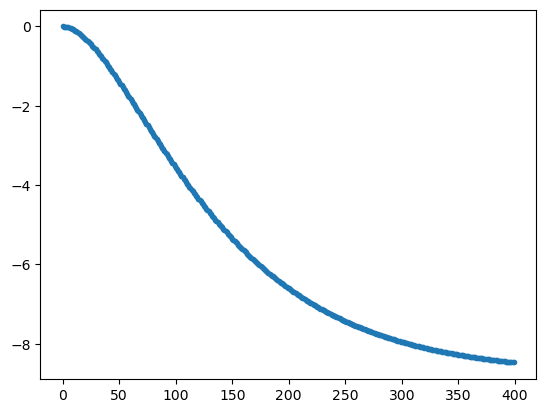

In [19]:
i = EX.index('EX_lac_L(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(sum_results[i,:,1].cumsum(),'.')

[0.         0.08443468 0.08355911 0.08269554 0.08184117 0.08099589
 0.0801596  0.0793322  0.07851359 0.07770367 0.07690234 0.07610952
 0.0753251  0.07454899 0.0737811  0.07302133 0.0722696  0.07152582
 0.0707899  0.07006176 0.06934129 0.06862843 0.06792309 0.06722518
 0.06653463 0.06585134 0.06517525 0.06450627 0.06384432 0.06318934
 0.06254123 0.06189993 0.06126535 0.06063744 0.06001611 0.05940129
 0.05879292 0.05819091 0.05759521 0.05700574 0.05642613 0.05586382
 0.05530708 0.05475587 0.05421014 0.05366983 0.05313489 0.05260526
 0.05208089 0.05156174 0.05104774 0.05053885 0.05003501 0.04953619
 0.04904232 0.04855336 0.04806926 0.04758997 0.04711545 0.04664564
 0.04618051 0.04572    0.04526407 0.04481268 0.04436577 0.04392331
 0.04348525 0.04305154 0.04262215 0.04219703 0.04177614 0.04135944
 0.04094689 0.04053843 0.04013405 0.03973368 0.0393373  0.03894487
 0.03855634 0.03817168 0.03779084 0.0374138  0.03704051 0.03667094
 0.03630504 0.03594279 0.03558414 0.03522907 0.03487753 0.0345

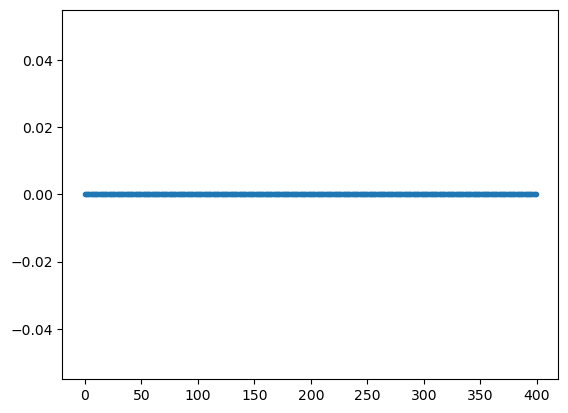

In [21]:
i = EX.index('EX_but(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(sum_results[i,:,0].cumsum(),'.')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

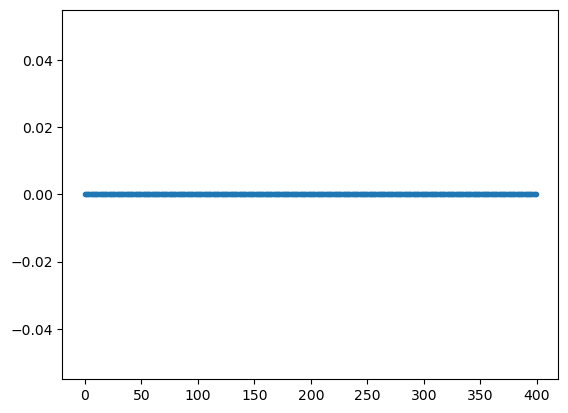

In [20]:
i = EX.index('EX_ac(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(sum_results[i,:,0].cumsum(),'.')

In [25]:
df = pd.DataFrame(sum_results, index=EX)
tol = 1e-9
nonzero_rows = df[(df.abs() > tol).any(axis=1)]
print(nonzero_rows)

                      0          1
EX_ac(e)      -0.241277   0.241361
EX_asn_L(e)   -0.014503  -0.069234
EX_biomass(e)  0.061798   0.295012
EX_ca2(e)     -0.000483  -0.002304
EX_cl(e)      -0.000483  -0.002304
EX_co2(e)      0.409777  17.435447
EX_cobalt2(e) -0.000483  -0.002304
EX_cu2(e)     -0.000483  -0.002304
EX_etoh(e)     0.251709   0.000000
EX_fe2(e)     -0.000483  -0.002304
EX_fe3(e)     -0.000483  -0.002304
EX_for(e)     -0.007816   0.013823
EX_glc_D(e)   -5.000000  -5.000000
EX_glycys(e)  -0.016175  -0.030858
EX_h(e)        9.239514  -6.268483
EX_h2o(e)      1.485937   5.801999
EX_his_L(e)   -0.005724   0.109512
EX_hxan(e)    -0.027299  -0.134927
EX_k(e)       -0.000483  -0.002304
EX_lac_L(e)    9.124742  -9.123952
EX_leu_L(e)   -0.027108  -0.129410
EX_met_L(e)    0.000000  -0.046361
EX_mg2(e)     -0.000483  -0.002304
EX_mn2(e)     -0.000483  -0.002304
EX_nac(e)     -0.000965  -0.004608
EX_nh4(e)     -0.465597  -1.164539
EX_pi(e)      -0.091465  -0.423214
EX_pnto_R(e)  -0.000